# 02 DBSCAN

In [ ]:
# Setup
!pip install -q numpy pandas matplotlib seaborn scikit-learn umap-learn mlxtend

### 2.2 DBSCAN (Density-Based Spatial Clustering)

**DBSCAN** e un algoritmo di clustering basato sulla densita. A differenza di K-Means, non richiede di specificare il numero di cluster e puo trovare cluster di forma arbitraria.

#### Concetti chiave

- **Epsilon ($\varepsilon$)**: raggio del vicinato di un punto
- **MinPts**: numero minimo di punti per definire una regione densa
- **Core Point**: punto con almeno MinPts punti nel suo $\varepsilon$-vicinato
- **Border Point**: punto nel vicinato di un core point ma non core point stesso
- **Noise Point**: punto che non e ne core ne border (outlier)

#### Vantaggi e svantaggi

| Vantaggi | Svantaggi |
|----------|----------|
| Non richiede K | Sensibile ai parametri eps e min_samples |
| Trova cluster di forma arbitraria | Difficolta con cluster di densita variabile |
| Identifica automaticamente outlier | Problematico in alta dimensionalita |
| Robusto al rumore | Puo essere lento su grandi dataset |

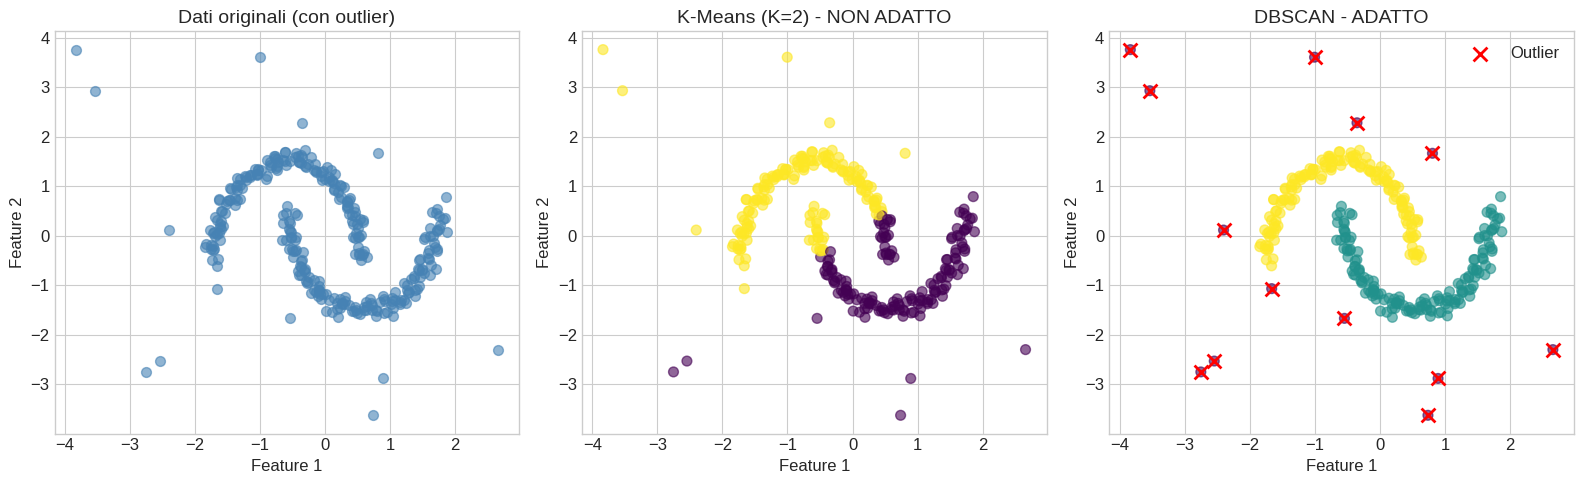

RISULTATI DBSCAN
Numero di cluster trovati: 2
Punti classificati come rumore: 13
Silhouette Score (escludendo rumore): 0.384


In [5]:
# SEZIONE 2.2: DBSCAN
# Questa sezione e completamente incapsulata

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Dataset a forma di luna - cluster non sferici
X_moons, y_moons = make_moons(n_samples=300, noise=0.05, random_state=42)
scaler_dbscan = StandardScaler()
X_moons_scaled = scaler_dbscan.fit_transform(X_moons)

# Aggiungiamo outlier
np.random.seed(42)
outliers = np.random.uniform(low=-4, high=4, size=(15, 2))
X_moons_with_outliers = np.vstack([X_moons_scaled, outliers])

# Confronto K-Means vs DBSCAN
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Dati originali
axes[0].scatter(X_moons_with_outliers[:, 0], X_moons_with_outliers[:, 1],
                c='steelblue', alpha=0.6, s=50)
axes[0].set_title('Dati originali (con outlier)', fontsize=14)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# K-Means (fallisce con cluster non sferici)
kmeans_moons = KMeans(n_clusters=2, random_state=42)
labels_kmeans_moons = kmeans_moons.fit_predict(X_moons_with_outliers)
axes[1].scatter(X_moons_with_outliers[:, 0], X_moons_with_outliers[:, 1],
                c=labels_kmeans_moons, cmap='viridis', alpha=0.6, s=50)
axes[1].set_title('K-Means (K=2) - NON ADATTO', fontsize=14)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# DBSCAN
dbscan_model = DBSCAN(
    eps=0.3,          # Raggio del vicinato
    min_samples=5,    # Punti minimi per definire core point
    metric='euclidean'
)
labels_dbscan = dbscan_model.fit_predict(X_moons_with_outliers)

# Colorazione: outlier in nero
colors_dbscan = labels_dbscan.copy()
scatter = axes[2].scatter(X_moons_with_outliers[:, 0], X_moons_with_outliers[:, 1],
                          c=colors_dbscan, cmap='viridis', alpha=0.6, s=50)

# Evidenzia outlier
outlier_mask = labels_dbscan == -1
axes[2].scatter(X_moons_with_outliers[outlier_mask, 0],
                X_moons_with_outliers[outlier_mask, 1],
                c='red', marker='x', s=100, linewidths=2, label='Outlier')
axes[2].set_title('DBSCAN - ADATTO', fontsize=14)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()

plt.tight_layout()
plt.show()

# Statistiche
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)

print("=" * 50)
print("RISULTATI DBSCAN")
print("=" * 50)
print(f"Numero di cluster trovati: {n_clusters_dbscan}")
print(f"Punti classificati come rumore: {n_noise_dbscan}")

# Silhouette solo sui punti non rumore
if n_clusters_dbscan > 1:
    mask_non_noise = labels_dbscan != -1
    sil_score = silhouette_score(X_moons_with_outliers[mask_non_noise],
                                  labels_dbscan[mask_non_noise])
    print(f"Silhouette Score (escludendo rumore): {sil_score:.3f}")

**Osservazioni importanti su DBSCAN**

- La scelta di `eps` e cruciale: troppo piccolo = troppi cluster/rumore, troppo grande = pochi cluster
- Usare il k-distance graph per stimare `eps` ottimale
- `min_samples` tipicamente >= dimensionalita + 1
- Etichetta -1 indica rumore/outlier

**Quando usare DBSCAN**

- Cluster di forma non sferica (lune, cerchi concentrici)
- Presenza di outlier significativi
- Non si conosce il numero di cluster
- Dati con densita relativamente uniforme